# 0. Download seismograms

This tutorial considers a small dataset for earthquake detection and location from continuous data. The dataset consists of one day of data from eight broadband seismic stations with three components in the North Anatolian fault zone. 

In the present notebook, we download the continuous dataset and save it for later use. We focus on the records during the day 2013-04-23 when a magnitude 3.3 earthquake nucleated in the middle of the seismic array at 7 km depth. You will find information about this earthquake on the [international seismological center event page](http://www.isc.ac.uk/cgi-bin/web-db-run?request=COMPREHENSIVE&out_format=CATCSV&searchshape=RECT&bot_lat=40.60&top_lat=40.76&left_lon=30.20&right_lon=30.45&ctr_lat=&ctr_lon=&radius=&max_dist_units=deg&srn=&grn=&start_year=2012&start_month=1&start_day=23&start_time=00%3A00%3A00&end_year=2013&end_month=7&end_day=01&end_time=00%3A00%3A00&min_dep=&max_dep=&min_mag=3&max_mag=&req_mag_type=Any&req_mag_agcy=&include_links=on).



> **Note:** this notebook uses the `mass_downloader` of `obspy` to find and download the data from the IRIS data center. The download duration can change depending on your location, do not hesitate to consider another dataset that would suit you better. 
A more extensive tutorial about the mass downloader is available in the [obspy documentation](https://docs.obspy.org/packages/autogen/obspy.clients.fdsn.mass_downloader.html).

#### Dataset information

| Dataset info | Value |
|-|-|
| Location | North anatolian fault zone |
| Number of stations | 8 |
| Number of files | 24 |
| File size (HH) | 17 MB |
| File size (BH) | 8 MB |
| Download duration | 1 minute (fastest) to 10 minutes (slowest) |
| Overall disk usage | 230 MB |

#### Contents of this notebook
* [Destination path](#download-destination-path)

* [Download preparation](#prepare-the-downloader)
* [Download](#download)
* [Show inventory on a map](#show-inventory)

In [1]:
import cartopy
import os

from matplotlib import pyplot as plt
from obspy import UTCDateTime, read_inventory
from obspy.clients.fdsn import mass_downloader

## Download destination path

By default, the package comes with a `data/` folder which can be used to store the downloaded waveforms. The waveforms downloaded there should not be pushed to a new branch if you want to contribute. We indicated the `.mseed` format in the `.gitignore` file; if you download any other data format, please update `.gitignore` accordingly. Feel free to change it to any convenient path of your choice. 

In [2]:
DIRPATH_DESTINATION = "../data/raw/"

If we remove the `data/` repository in future package releases, this next cell will ensure we can still save the data.

In [3]:
os.makedirs(DIRPATH_DESTINATION, exist_ok=True)

## Prepare the downloader

We here define the geographical domain and other restrictions such as data quality and temporal coverage for download. 

### Geographical domain
We restrict the download to the North Anatolian domain thanks to the `RectangularDomain` function.

In [4]:
domain = mass_downloader.RectangularDomain(
    minlatitude=40.60,
    maxlatitude=40.76,
    minlongitude=30.20,
    maxlongitude=30.44,
)

### Temporal domain and quality restrictions

We select the data from the eight seismic stations on channels `HH` or `BH` with continuous data over one day (2012/07/26) within the `Restrictions` function.

In [5]:
restrictions = mass_downloader.Restrictions(
    starttime=UTCDateTime("2013-04-23"),
    endtime=UTCDateTime("2013-04-24"),
    chunklength_in_sec=86400.0,
    network="YH",
    location="*",
    channel="BH*,HH*",
    station="SAUV,SPNC,DC08,DC07,DC06,DD06,DE07,DE08",
    reject_channels_with_gaps=False,
    minimum_length=0.0,
    minimum_interstation_distance_in_m=100.0,
    channel_priorities=["HH[ZNE]", "BH[ZNE]"],
)

## Download

The download can take several minutes, depending on the internet connection and the machine.

In [6]:
# Downloader instance
downloader = mass_downloader.MassDownloader(providers=["IRIS"])

# Download
downloader.download(
    domain,
    restrictions,
    mseed_storage=DIRPATH_DESTINATION,
    stationxml_storage=DIRPATH_DESTINATION,
)

[2022-08-07 07:58:42,034] - obspy.clients.fdsn.mass_downloader - INFO: Initializing FDSN client(s) for IRIS.
[2022-08-07 07:58:42,819] - obspy.clients.fdsn.mass_downloader - INFO: Successfully initialized 1 client(s): IRIS.
[2022-08-07 07:58:42,823] - obspy.clients.fdsn.mass_downloader - INFO: Total acquired or preexisting stations: 0
[2022-08-07 07:58:42,824] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Requesting reliable availability.
[2022-08-07 07:58:43,253] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Successfully requested availability (0.43 seconds)
[2022-08-07 07:58:43,256] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Found 8 stations (24 channels).
[2022-08-07 07:58:43,259] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Will attempt to download data from 8 stations.
[2022-08-07 07:58:43,264] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Status for 24 time intervals/channels before downloading: EXISTS

{'IRIS': <obspy.clients.fdsn.mass_downloader.download_helpers.ClientDownloadHelper at 0x2aaab6d87a60>}

## Show inventory

We illustrate the downloaded dataset station positions in space. The inventory contains all metadata related to a given `seed_id`. Please check [this obspy tutorial](https://docs.obspy.org/master/packages/autogen/obspy.core.inventory.inventory.Inventory.plot.html) for more information.

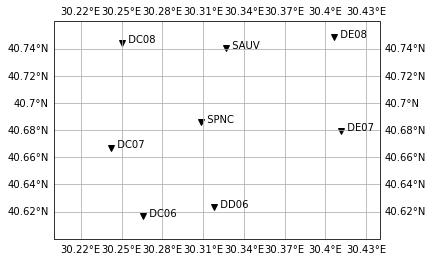

In [7]:
MAP_EXTENT = (
    domain.minlongitude,
    domain.maxlongitude,
    domain.minlatitude,
    domain.maxlatitude,
)

# Read inventory
inventory = read_inventory(os.path.join(DIRPATH_DESTINATION, "*.xml"))

# Create axes
ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.set_extent(MAP_EXTENT)
ax.gridlines(draw_labels=True)
ax.coastlines()

# Show
for network in inventory:
    for station in network:
        ax.plot(station.longitude, station.latitude, "kv")
        ax.text(station.longitude, station.latitude, "  " + station.code)
